In [1]:
"""Figure core creation: Fig1

Formatting of the figures may not be identical to the paper, but they contain the same data points.
"""

# pylint: disable=import-error, redefined-outer-name, use-dict-literal, too-many-lines, too-many-branches, duplicate-code

'Figure core creation: Fig1\n\nFormatting of the figures may not be identical to the paper, but they contain the same data points.\n'

In [2]:
%load_ext autoreload
%autoreload 2

## Setup

In [3]:
from __future__ import annotations

import copy
import logging
import re
import tempfile
from collections import defaultdict
from pathlib import Path
from typing import Dict, Optional, Tuple

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from IPython.core.display import Image
from IPython.display import display
from plotly.subplots import make_subplots
from sklearn.metrics import auc, confusion_matrix as sk_cm, roc_curve
from sklearn.preprocessing import label_binarize

from epi_ml.core.confusion_matrix import ConfusionMatrixWriter
from epi_ml.utils.notebooks.paper.metrics_per_assay import MetricsPerAssay
from epi_ml.utils.notebooks.paper.paper_utilities import (
    ASSAY,
    ASSAY_MERGE_DICT,
    ASSAY_ORDER,
    CELL_TYPE,
    SEX,
    IHECColorMap,
    MetadataHandler,
    SplitResultsHandler,
    extract_input_sizes_from_output_files,
    merge_similar_assays,
)

In [4]:
base_dir = Path.home() / "Projects/epiclass/output/paper"
paper_dir = base_dir
if not paper_dir.exists():
    raise FileNotFoundError(f"Directory {paper_dir} does not exist.")

base_data_dir = base_dir / "data"
base_fig_dir = base_dir / "figures"

In [5]:
IHECColorMap = IHECColorMap(base_fig_dir)
assay_colors = IHECColorMap.assay_color_map
cell_type_colors = IHECColorMap.cell_type_color_map

In [6]:
split_results_handler = SplitResultsHandler()

metadata_handler = MetadataHandler(paper_dir)
metadata_v2 = metadata_handler.load_metadata("v2")
metadata_v2_df = metadata_v2.to_df()

In [7]:
gen_data_dir = base_data_dir / "training_results" / "dfreeze_v2"
if not gen_data_dir.exists():
    raise FileNotFoundError(f"Directory {gen_data_dir} does not exist.")

data_dir_100kb = gen_data_dir / "hg38_100kb_all_none"
if not data_dir_100kb.exists():
    raise FileNotFoundError(f"Directory {data_dir_100kb} does not exist.")

## Fig 1

### Fig 1B-C Prep - Various feature sets performance (1kb to 1mb) - Assay and Biospecimen

In [8]:
mixed_data_dir = gen_data_dir / "mixed"
if not mixed_data_dir.exists():
    raise FileNotFoundError(f"Directory {mixed_data_dir} does not exist.")

In [9]:
feature_sets_14 = [
    "hg38_10mb_all_none_1mb_coord",
    "hg38_100kb_random_n316_none",
    "hg38_1mb_all_none",
    "hg38_100kb_random_n3044_none",
    "hg38_100kb_all_none",
    "hg38_gene_regions_100kb_coord_n19864",
    "hg38_10kb_random_n30321_none",
    "hg38_regulatory_regions_n30321",
    "hg38_1kb_random_n30321_none",
    "hg38_cpg_topvar_200bp_10kb_coord_n30k",
    "hg38_10kb_all_none",
    "hg38_regulatory_regions_n303114",
    "hg38_1kb_random_n303114_none",
    "hg38_cpg_topvar_200bp_10kb_coord_n300k",
]
fig1_sets = [
    "hg38_10mb_all_none_1mb_coord",
    "hg38_100kb_random_n316_none",
    "hg38_1mb_all_none",
    "hg38_100kb_random_n3044_none",
    "hg38_100kb_all_none",
    "hg38_10kb_random_n30321_none",
    "hg38_1kb_random_n30321_none",
    "hg38_10kb_all_none",
    "hg38_1kb_random_n303114_none",
]
flagship_selection_4cat = [
    "hg38_100kb_all_none",
    "hg38_gene_regions_100kb_coord_n19864",
    "hg38_regulatory_regions_n30321",
    "hg38_cpg_topvar_200bp_10kb_coord_n30k",
]
different_nature_sets = [
    "hg38_regulatory_regions_n30321",
    "hg38_regulatory_regions_n303114",
    "hg38_cpg_topvar_200bp_10kb_coord_n30k",
    "hg38_cpg_topvar_200bp_10kb_coord_n300k",
    "hg38_cpg_topvar_2bp_10kb_coord_n30k",
    "hg38_cpg_topvar_2bp_10kb_coord_n300k",
    "hg38_gene_regions_100kb_coord_n19864",
    "hg38_100kb_all_none",
    "hg38_10kb_all_none",
    "hg38_10kb_random_n30321_none",
    "hg38_1kb_random_n30321_none",
    "hg38_1kb_random_n303114_none",
]

metric_orders_map = {
    "flagship_selection_4cat": flagship_selection_4cat,
    "fig1_sets": fig1_sets,
    "feature_sets_14": feature_sets_14,
    "different_nature_sets": different_nature_sets,
}

In [10]:
input_sizes = extract_input_sizes_from_output_files(mixed_data_dir)  # type: ignore
input_sizes: Dict[str, int] = {k: v.pop() for k, v in input_sizes.items() if len(v) == 1}  # type: ignore

In [11]:
set_selection_name = "feature_sets_14"

In [12]:
logdir = (
    base_fig_dir
    / "fig2_EpiAtlas_other"
    / "fig2--reduced_feature_sets"
    / "test"
    / set_selection_name
)
logdir.mkdir(parents=True, exist_ok=True)

In [13]:
all_metrics = split_results_handler.obtain_all_feature_set_data(
    parent_folder=mixed_data_dir,
    merge_assays=True,
    return_type="metrics",
    include_categories=[ASSAY, CELL_TYPE],
    include_sets=metric_orders_map[set_selection_name],
    exclude_names=["16ct", "27ct", "7c", "chip-seq-only"],
)

# Order the metrics
all_metrics = {
    name: all_metrics[name]  # type: ignore
    for name in metric_orders_map[set_selection_name]
    if name in all_metrics
}

In [14]:
# correct a name
try:
    all_metrics["hg38_100kb_all_none"][ASSAY] = all_metrics["hg38_100kb_all_none"][  # type: ignore
        f"{ASSAY}_11c"
    ]
    del all_metrics["hg38_100kb_all_none"][f"{ASSAY}_11c"]
except KeyError:
    pass

In [15]:
resolution_colors = {
    "100kb": px.colors.qualitative.Safe[0],
    "10kb": px.colors.qualitative.Safe[1],
    "1kb": px.colors.qualitative.Safe[2],
    "regulatory": px.colors.qualitative.Safe[3],
    "gene": px.colors.qualitative.Safe[4],
    "cpg": px.colors.qualitative.Safe[5],
    "1mb": px.colors.qualitative.Safe[6],
    "5mb": px.colors.qualitative.Safe[7],
    "10mb": px.colors.qualitative.Safe[8],
}

In [16]:
def graph_feature_set_metrics(
    all_metrics: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
    input_sizes: Dict[str, int],
    logdir: Path | None = None,
    sort_by_input_size: bool = False,
    name: str | None = None,
    y_range: Tuple[float, float] | None = None,
    boxpoints: str = "all",
    width: int = 1200,
    height: int = 1200,
) -> None:
    """Graph the metrics for all feature sets.

    Args:
        all_metrics (Dict[str, Dict[str, Dict[str, Dict[str, float]]]): A dictionary containing all metrics for all feature sets.
            Format: {feature_set: {task_name: {split_name: metric_dict}}}
        input_sizes (Dict[str, int]): A dictionary containing the input sizes for all feature sets.
        logdir (Path): The directory where the figure will be saved. If None, the figure will only be displayed.
        sort_by_input_size (bool): Whether to sort the feature sets by input size.
        name (str|None): The name of the figure.
        y_range (Tuple[float, float]|None): The y-axis range for the figure.
        boxpoints (str): The type of boxpoints to display. Can be "all" or "outliers". Defaults to "all".
    """
    if boxpoints not in ["all", "outliers"]:
        raise ValueError("Invalid boxpoints value.")

    reference_hdf5_type = "hg38_100kb_all_none"
    metadata_categories = list(all_metrics[reference_hdf5_type].keys())

    non_standard_names = {ASSAY: f"{ASSAY}_11c", SEX: f"{SEX}_w-mixed"}
    non_standard_assay_task_names = ["hg38_100kb_all_none"]
    non_standard_sex_task_name = [
        "hg38_100kb_all_none",
        "hg38_regulatory_regions_n30321",
        "hg38_regulatory_regions_n303114",
    ]
    used_resolutions = set()
    for i in range(len(metadata_categories)):
        category_idx = i
        category_fig = make_subplots(
            rows=1,
            cols=2,
            shared_yaxes=True,
            subplot_titles=["Accuracy", "F1-score (macro)"],
            x_title="Feature set",
            y_title="Metric value",
        )

        trace_names = []
        order = list(all_metrics.keys())
        if sort_by_input_size:
            order = sorted(
                all_metrics.keys(),
                key=lambda x: input_sizes[x],
            )
        for feature_set_name in order:
            # print(feature_set_name)
            tasks_dicts = all_metrics[feature_set_name]
            meta_categories = copy.deepcopy(metadata_categories)

            if feature_set_name not in input_sizes:
                print(f"Skipping {feature_set_name}, no input size found.")
                continue

            task_name = meta_categories[category_idx]
            if "split" in task_name:
                raise ValueError("Split in task name. Wrong metrics dict.")

            try:
                task_dict = tasks_dicts[task_name]
            except KeyError as err:
                if SEX in str(err) and feature_set_name in non_standard_sex_task_name:
                    task_dict = tasks_dicts[non_standard_names[SEX]]
                elif (
                    ASSAY in str(err)
                    and feature_set_name in non_standard_assay_task_names
                ):
                    task_dict = tasks_dicts[non_standard_names[ASSAY]]
                else:
                    print("Skipping", feature_set_name, task_name)
                    continue

            input_size = input_sizes[feature_set_name]

            feature_set_name = feature_set_name.replace("_none", "")
            feature_set_name = feature_set_name.replace("hg38_", "")

            resolution = feature_set_name.split("_")[0]
            used_resolutions.add(resolution)

            trace_name = f"{input_size}|{feature_set_name}"
            trace_names.append(trace_name)

            # Accuracy
            metric = "Accuracy"
            y_vals = [task_dict[split][metric] for split in task_dict]
            hovertext = [
                f"{split}: {metrics_dict[metric]:.4f}"
                for split, metrics_dict in task_dict.items()
            ]
            category_fig.add_trace(
                go.Box(
                    y=y_vals,
                    name=trace_name,
                    boxmean=True,
                    boxpoints=boxpoints,
                    marker=dict(size=3, color="black"),
                    line=dict(width=1, color="black"),
                    fillcolor=resolution_colors[resolution],
                    hovertemplate="%{text}",
                    text=hovertext,
                    legendgroup=resolution,
                    showlegend=False,
                ),
                row=1,
                col=1,
            )

            metric = "F1_macro"
            y_vals = [task_dict[split][metric] for split in task_dict]
            hovertext = [
                f"{split}: {metrics_dict[metric]:.4f}"
                for split, metrics_dict in task_dict.items()
            ]
            category_fig.add_trace(
                go.Box(
                    y=y_vals,
                    name=trace_name,
                    boxmean=True,
                    boxpoints=boxpoints,
                    marker=dict(size=3, color="black"),
                    line=dict(width=1, color="black"),
                    fillcolor=resolution_colors[resolution],
                    hovertemplate="%{text}",
                    text=hovertext,
                    legendgroup=resolution,
                    showlegend=False,
                ),
                row=1,
                col=2,
            )

        title = f"Neural network performance - {metadata_categories[category_idx]}"
        if name is not None:
            title += f" - {name}"
        category_fig.update_layout(
            width=width,
            height=height,
            title=title,
        )

        # dummy scatters for resolution colors
        for resolution, color in resolution_colors.items():
            if resolution not in used_resolutions:
                continue
            category_fig.add_trace(
                go.Scatter(
                    x=[None],
                    y=[None],
                    mode="markers",
                    name=resolution,
                    marker=dict(color=color, size=5),
                    showlegend=True,
                    legendgroup=resolution,
                )
            )

        category_fig.update_layout(legend=dict(itemsizing="constant"))

        # y-axis
        if y_range:
            category_fig.update_yaxes(range=y_range)
        else:
            if ASSAY in task_name:
                category_fig.update_yaxes(range=[0.96, 1.001])
            if CELL_TYPE in task_name:
                category_fig.update_yaxes(range=[0.75, 1])

        # Save figure
        if logdir:
            base_name = f"feature_set_metrics_{metadata_categories[category_idx]}"
            if name is not None:
                base_name = base_name + f"_{name}"
            category_fig.write_html(logdir / f"{base_name}.html")
            category_fig.write_image(logdir / f"{base_name}.svg")
            category_fig.write_image(logdir / f"{base_name}.png")

        category_fig.show()

#### Fig 1B

In [17]:
metrics_fig1b = {name: all_metrics[name] for name in ["hg38_100kb_all_none"]}

metrics_fig1b_1 = {
    "hg38_100kb_all_none": {ASSAY: metrics_fig1b["hg38_100kb_all_none"][ASSAY]}
}

metrics_fig1b_2 = {
    "hg38_100kb_all_none": {CELL_TYPE: metrics_fig1b["hg38_100kb_all_none"][CELL_TYPE]}
}
graph_feature_set_metrics(
    all_metrics=metrics_fig1b_1,  # type: ignore
    input_sizes=input_sizes,
    boxpoints="all",
    width=700,
    height=600,
    y_range=(0.98, 1.001),
)

graph_feature_set_metrics(
    all_metrics=metrics_fig1b_2,  # type: ignore
    input_sizes=input_sizes,
    boxpoints="all",
    width=700,
    height=600,
    y_range=(0.93, 1.001),
)

#### Fig 1C

In [18]:
metrics_fig1c = {name: all_metrics[name] for name in fig1_sets}

graph_feature_set_metrics(
    all_metrics=metrics_fig1c,  # type: ignore
    input_sizes=input_sizes,
    boxpoints="all",
)

In [19]:
def parse_bin_size(feature_set_name: str) -> Optional[float]:
    """
    Parses the feature set name to extract a numerical bin size in base pairs.
    Handles formats like '100kb', '5mb', 'regulatory', 'gene', 'cpg'.

    Returns numerical size (float) or None if unparseable or non-numeric.
    Assigns placeholder values for non-genomic-range types if needed,
    but for a continuous axis, it's better to return None or filter later.
    """
    name_parts = feature_set_name.replace("hg38_", "").split("_")
    if not name_parts:
        return None

    resolution_str = name_parts[0].lower()

    # Handle standard genomic ranges
    match_kb = re.match(r"(\d+)kb", resolution_str)
    if match_kb:
        return float(match_kb.group(1)) * 1_000
    match_mb = re.match(r"(\d+)mb", resolution_str)
    if match_mb:
        return float(match_mb.group(1)) * 1_000_000

    # Handle non-range types - decide how to represent them.
    # Option 1: Return None (they won't be plotted on the numeric axis)
    # Option 2: Assign arbitrary numbers (might distort scale)
    # Option 3: Could use different marker symbols later if needed
    if resolution_str in ["regulatory", "gene", "cpg"]:
        # For now, let's return None so they are filtered out from the numeric plot
        # Or assign a placeholder if you want to handle them differently:
        # if resolution_str == 'regulatory': return 1e1 # Example placeholder
        # if resolution_str == 'gene': return 1e2 # Example placeholder
        # if resolution_str == 'cpg': return 1e0 # Example placeholder
        return None  # Returning None is cleaner for a pure numeric axis

    # Fallback for unrecognised formats
    try:
        # Maybe it's just a number (e.g., representing window size)?
        return float(resolution_str)
    except ValueError:
        return None

In [20]:
def graph_feature_set_scatter(
    all_metrics: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
    input_sizes: Dict[str, int],
    logdir: Optional[Path] = None,
    metric_to_plot: str = "Accuracy",
    name: Optional[str] = None,
    metric_range: Optional[Tuple[float, float]] = None,
    assay_task_key: str = ASSAY,
    sex_task_key: str = SEX,
    cell_type_task_key: str = CELL_TYPE,
) -> None:
    """
    Graphs performance metrics as a scatter plot with modifications.

    X-axis: Number of Features (log scale).
    Y-axis: Average performance metric (e.g., Accuracy, F1_macro) across folds.
            Vertical lines indicate the min/max range across folds.
    Color: Bin Size (bp, log scale).

    Args:
        all_metrics: Nested dict {feature_set: {task_name: {split_name: metric_dict}}}.
        input_sizes: Dict {feature_set: num_features}.
        logdir: Directory to save figures. If None, display only.
        metric_to_plot: The metric key to use for the Y-axis ('Accuracy', 'F1_macro').
        name: Optional suffix for figure titles and filenames.
        metric_range: Optional tuple (min, max) to set the Y-axis range.
        assay_task_key: Key used for the assay prediction task.
        sex_task_key: Key used for the sex prediction task.
        cell_type_task_key: Key used for the cell type prediction task.
    """
    if metric_to_plot not in ["Accuracy", "F1_macro"]:
        raise ValueError("metric_to_plot must be 'Accuracy' or 'F1_macro'")

    # --- Standard Name Handling (simplified from original) ---
    non_standard_names = {ASSAY: f"{ASSAY}_11c", SEX: f"{SEX}_w-mixed"}
    # These lists are no longer strictly needed by the simplified lookup, but kept for context
    # non_standard_assay_task_names = ["hg38_100kb_all_none"]
    # non_standard_sex_task_name = [
    #     "hg38_100kb_all_none",
    #     "hg38_regulatory_regions_n30321",
    #     "hg38_regulatory_regions_n303114",
    # ]

    # --- Find reference and task names ----
    reference_hdf5_type = next(iter(all_metrics), None)
    if reference_hdf5_type is None or not all_metrics.get(reference_hdf5_type):
        print(
            "Warning: Could not determine tasks from all_metrics. Trying default tasks."
        )
        cleaned_metadata_categories = {assay_task_key, sex_task_key, cell_type_task_key}
    else:
        metadata_categories = list(all_metrics[reference_hdf5_type].keys())
        cleaned_metadata_categories = set()
        for cat in metadata_categories:
            original_name = cat
            for standard, non_standard in non_standard_names.items():
                if cat == non_standard:
                    original_name = standard
                    break
            cleaned_metadata_categories.add(original_name)

    # --- Define Bin size categories and Colors ---
    bin_category_names = ["1Kb", "10Kb", "100Kb", "1Mb", "10Mb"]
    bin_category_values = [1000, 10000, 100 * 1000, 1000 * 1000, 10000 * 1000]
    discrete_colors = px.colors.sequential.Viridis_r
    color_map = {
        name: discrete_colors[i * 2] for i, name in enumerate(bin_category_names)
    }

    print(f"Plotting for tasks: {list(cleaned_metadata_categories)}")
    for category_name in cleaned_metadata_categories:
        plot_data_points = []

        for feature_set_name_orig in all_metrics.keys():
            try:
                num_features = input_sizes[feature_set_name_orig]
            except KeyError as e:
                raise ValueError(
                    f"Feature set '{feature_set_name_orig}' not found in input_sizes"
                ) from e

            # Parse Bin Size
            bin_size = parse_bin_size(feature_set_name_orig)
            if bin_size is None:
                print(
                    f"Skipping {feature_set_name_orig}, could not parse numeric bin size."
                )
                continue

            # 3. Get Metric Values (Average, Min, Max)
            tasks_dicts = all_metrics[feature_set_name_orig]

            # --- Task Name Lookup ---
            # 1. Try the standard category name first
            # 2. If standard name not found, use non-standard name
            task_dict = None
            task_name = category_name
            if category_name in tasks_dicts:
                task_dict = tasks_dicts[category_name]
            else:
                non_standard_task_name = non_standard_names.get(category_name)
                if non_standard_task_name and non_standard_task_name in tasks_dicts:
                    task_name = non_standard_task_name
                    task_dict = tasks_dicts[non_standard_task_name]

                if task_dict is None:
                    raise ValueError(
                        f"Task '{category_name}' not found in feature set '{feature_set_name_orig}'"
                    )
            # --- End Task Name Lookup ---

            # Calculate average, min, max metric value across splits
            try:
                metric_values = []
                for split, split_data in task_dict.items():
                    if metric_to_plot in split_data:
                        metric_values.append(split_data[metric_to_plot])
                    else:
                        print(
                            f"Warning: Metric '{metric_to_plot}' not found in split '{split}' for {feature_set_name_orig} / {task_name}"
                        )

                if not metric_values:
                    print(
                        f"Warning: No metric values found for {feature_set_name_orig} / {task_name} / {metric_to_plot}"
                    )
                    continue

                avg_metric = np.mean(metric_values)
                min_metric = np.min(metric_values)
                max_metric = np.max(metric_values)

            except Exception as e:  # pylint: disable=broad-except
                raise ValueError(
                    f"Error calculating metrics for {feature_set_name_orig} / {task_name}: {e}"
                ) from e

            # Clean feature set name for hover text
            clean_name = feature_set_name_orig.replace("_none", "").replace("hg38_", "")

            # Store data for this point
            plot_data_points.append(
                {
                    "bin_size": bin_size,
                    "num_features": num_features,
                    "metric_value": avg_metric,
                    "min_metric": min_metric,  # For error bar low
                    "max_metric": max_metric,  # For error bar high
                    "name": clean_name,
                    "raw_name": feature_set_name_orig,
                }
            )

        if not plot_data_points:
            raise ValueError(
                f"No suitable data points found to plot for task: {category_name}"
            )

        # --- Determine Marker Symbols ---
        marker_symbols = []
        default_symbol = "circle"
        random_symbol = "cross"
        for p in plot_data_points:
            if "random" in p["raw_name"]:
                marker_symbols.append(random_symbol)
            else:
                marker_symbols.append(default_symbol)

        # --- Group Data by Category ---
        points_by_category = {name: [] for name in bin_category_names}
        for i, point_data in enumerate(plot_data_points):
            bin_size = point_data["bin_size"]
            assigned_category = None
            for cat_name, cat_value in zip(bin_category_names, bin_category_values):
                if bin_size == cat_value:
                    assigned_category = cat_name
                    break
            else:
                raise ValueError(f"Could not find category for bin size: {bin_size}")

            points_by_category[assigned_category].append(
                {
                    "x": point_data["num_features"],  # X is Num Features
                    "y": point_data["metric_value"],
                    "error_up": point_data["max_metric"] - point_data["metric_value"],
                    "error_down": point_data["metric_value"] - point_data["min_metric"],
                    "text": point_data["name"],
                    "customdata": [
                        point_data["min_metric"],
                        point_data["max_metric"],
                        point_data["bin_size"],
                    ],  # Keep bin size for hover
                    "symbol": marker_symbols[i],  # Assign symbol determined earlier
                }
            )

        # --- Create Figure and Add Traces PER CATEGORY ---
        fig = go.Figure()
        traces = []

        for cat_name in bin_category_names:  # Iterate in defined order for legend
            points_in_cat = points_by_category[cat_name]
            if not points_in_cat:
                continue

            category_color = color_map[cat_name]

            # Extract data for all points in this category
            x_vals = [p["x"] for p in points_in_cat]
            y_vals = [p["y"] for p in points_in_cat]
            error_up_vals = [p["error_up"] for p in points_in_cat]
            error_down_vals = [p["error_down"] for p in points_in_cat]
            text_vals = [p["text"] for p in points_in_cat]
            customdata_vals = [p["customdata"] for p in points_in_cat]
            symbols_vals = [p["symbol"] for p in points_in_cat]

            trace = go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="markers",
                name=cat_name,
                showlegend=False,
                legendgroup=cat_name,  # Group legend entries
                marker=dict(
                    color=category_color,
                    size=15,
                    symbol=symbols_vals,
                    line=dict(width=1, color="DarkSlateGrey"),
                ),
                error_y=dict(
                    type="data",
                    symmetric=False,
                    array=error_up_vals,
                    arrayminus=error_down_vals,
                    visible=True,
                    thickness=1.5,
                    width=15,
                    color=category_color,
                ),
                text=text_vals,
                customdata=customdata_vals,
                hovertemplate=(
                    f"<b>%{{text}}</b><br><br>"
                    f"Num Features: %{{x:,.0f}}<br>"
                    f"{metric_to_plot}: %{{y:.4f}}<br>"
                    f"Bin Size: %{{customdata[2]:,.0f}} bp<br>"
                    f"{metric_to_plot} Range (10-fold): %{{customdata[0]:.4f}} - %{{customdata[1]:.4f}}"
                    "<extra></extra>"
                ),
            )
            traces.append(trace)

        fig.add_traces(traces)

        # --- Add Legend ---
        # Add a hidden scatter trace with square markers for legend
        for cat_name in bin_category_names:
            category_color = color_map[cat_name]
            legend_trace = go.Scatter(
                x=[None],
                y=[None],
                mode="markers",
                name=cat_name,
                marker=dict(
                    color=category_color,
                    size=15,
                    symbol="square",
                    line=dict(width=1, color="DarkSlateGrey"),
                ),
                legendgroup=cat_name,
                showlegend=True,
            )
            fig.add_trace(legend_trace)

        # --- Update layout ---
        plot_title = f"{metric_to_plot} vs Number of Features - {category_name}"
        if name:
            plot_title += f" - {name}"
        xaxis_title = "Number of Features (log scale)"
        xaxis_type = "log"

        yaxis_title = metric_to_plot.replace("_", " ").title()
        yaxis_type = "linear"

        fig.update_layout(
            title=plot_title,
            xaxis_title=xaxis_title,
            yaxis_title=yaxis_title,
            xaxis_type=xaxis_type,
            yaxis_type=yaxis_type,
            yaxis_range=metric_range,
            width=900,
            height=750,
            hovermode="closest",
            legend_title_text="Bin Size",
        )

        if category_name == CELL_TYPE:
            fig.update_yaxes(range=[0.75, 1.005])
        elif category_name == ASSAY:
            fig.update_yaxes(range=[0.96, 1.001])

        # --- Save or show figure ---
        if logdir:
            logdir.mkdir(parents=True, exist_ok=True)
            # Include "modified" or similar in filename to distinguish
            base_name = f"feature_scatter_MODIFIED_v2_{category_name}_{metric_to_plot}"
            if name:
                base_name += f"_{name}"
            html_path = logdir / f"{base_name}.html"
            svg_path = logdir / f"{base_name}.svg"
            png_path = logdir / f"{base_name}.png"

            print(f"Saving modified plot for {category_name} to {html_path}")
            fig.write_html(html_path)
            fig.write_image(svg_path)
            fig.write_image(png_path)

        fig.show()

In [21]:
for metric in ["Accuracy", "F1_macro"]:
    graph_feature_set_scatter(
        all_metrics=metrics_fig1c,  # type: ignore
        input_sizes=input_sizes,
        metric_to_plot=metric,
        name="feature_set_scatter",
        # logdir=logdir,
    )

Plotting for tasks: ['assay_epiclass', 'harmonized_sample_ontology_intermediate']


Plotting for tasks: ['assay_epiclass', 'harmonized_sample_ontology_intermediate']


### Fig 1D - Confusion matrix

In [22]:
def create_confusion_matrix(
    df: pd.DataFrame,
    name: str = "confusion_matrix",
    logdir: Path | None = None,
    min_pred_score: float = 0,
    majority: bool = False,
) -> None:
    """Create a confusion matrix for the given DataFrame and save it to the logdir.

    Args:
        df (pd.DataFrame): The DataFrame containing the results.
        logdir (Path): The directory path for saving the figures.
        name (str): The name for the saved figures.
        min_pred_score (float): The minimum prediction score to consider.
        majority (bool): Whether to use majority vote (uuid-wise) for the predicted class.
    """
    # Compute confusion matrix
    classes = sorted(df["True class"].unique())
    if "Max pred" not in df.columns:
        df["Max pred"] = df[classes].max(axis=1)  # type: ignore
    filtered_df = df[df["Max pred"] > min_pred_score]

    if majority:
        # Majority vote for predicted class
        groupby_uuid = filtered_df.groupby(["uuid", "True class", "Predicted class"])[
            "Max pred"
        ].aggregate(["size", "mean"])

        if groupby_uuid["size"].max() > 3:
            raise ValueError("More than three predictions for the same uuid.")

        groupby_uuid = groupby_uuid.reset_index().sort_values(
            ["uuid", "True class", "size"], ascending=[True, True, False]
        )
        groupby_uuid = groupby_uuid.drop_duplicates(
            subset=["uuid", "True class"], keep="first"
        )
        filtered_df = groupby_uuid

    confusion_mat = sk_cm(
        filtered_df["True class"], filtered_df["Predicted class"], labels=classes
    )

    mat_writer = ConfusionMatrixWriter(labels=classes, confusion_matrix=confusion_mat)

    if logdir is None:
        logdir = Path(tempfile.gettempdir())

    files = mat_writer.to_all_formats(logdir, name=f"{name}_n{len(filtered_df)}")
    print(f"Saved confusion matrix to {logdir}:")
    for file in files:
        print(Path(file).name)

    for file in files:
        if "png" in file.name:
            display(Image(filename=file))

In [23]:
assay_split_dfs = split_results_handler.gather_split_results_across_methods(
    results_dir=data_dir_100kb, label_category=ASSAY, only_NN=True
)
concat_assay_df = split_results_handler.concatenate_split_results(assay_split_dfs)["NN"]

df_with_meta = metadata_handler.join_metadata(concat_assay_df, metadata_v2)  # type: ignore
if "Predicted class" not in df_with_meta.columns:
    raise ValueError("`Predicted class` not in DataFrame")

classifier_name = "MLP"
min_pred_score = 0
majority = False

name = f"{classifier_name}_pred>{min_pred_score}"

logdir = base_fig_dir / "fig1_EpiAtlas_assay" / "fig1_supp_D-assay_c11_confusion_matrices"
if majority:
    logdir = logdir / "per_uuid"
else:
    logdir = logdir / "per_file"
logdir.mkdir(parents=True, exist_ok=True)

Saved confusion matrix to /tmp:
confusion_matrix_n20922.csv
confusion_matrix_n20922_relative.csv
confusion_matrix_n20922.png


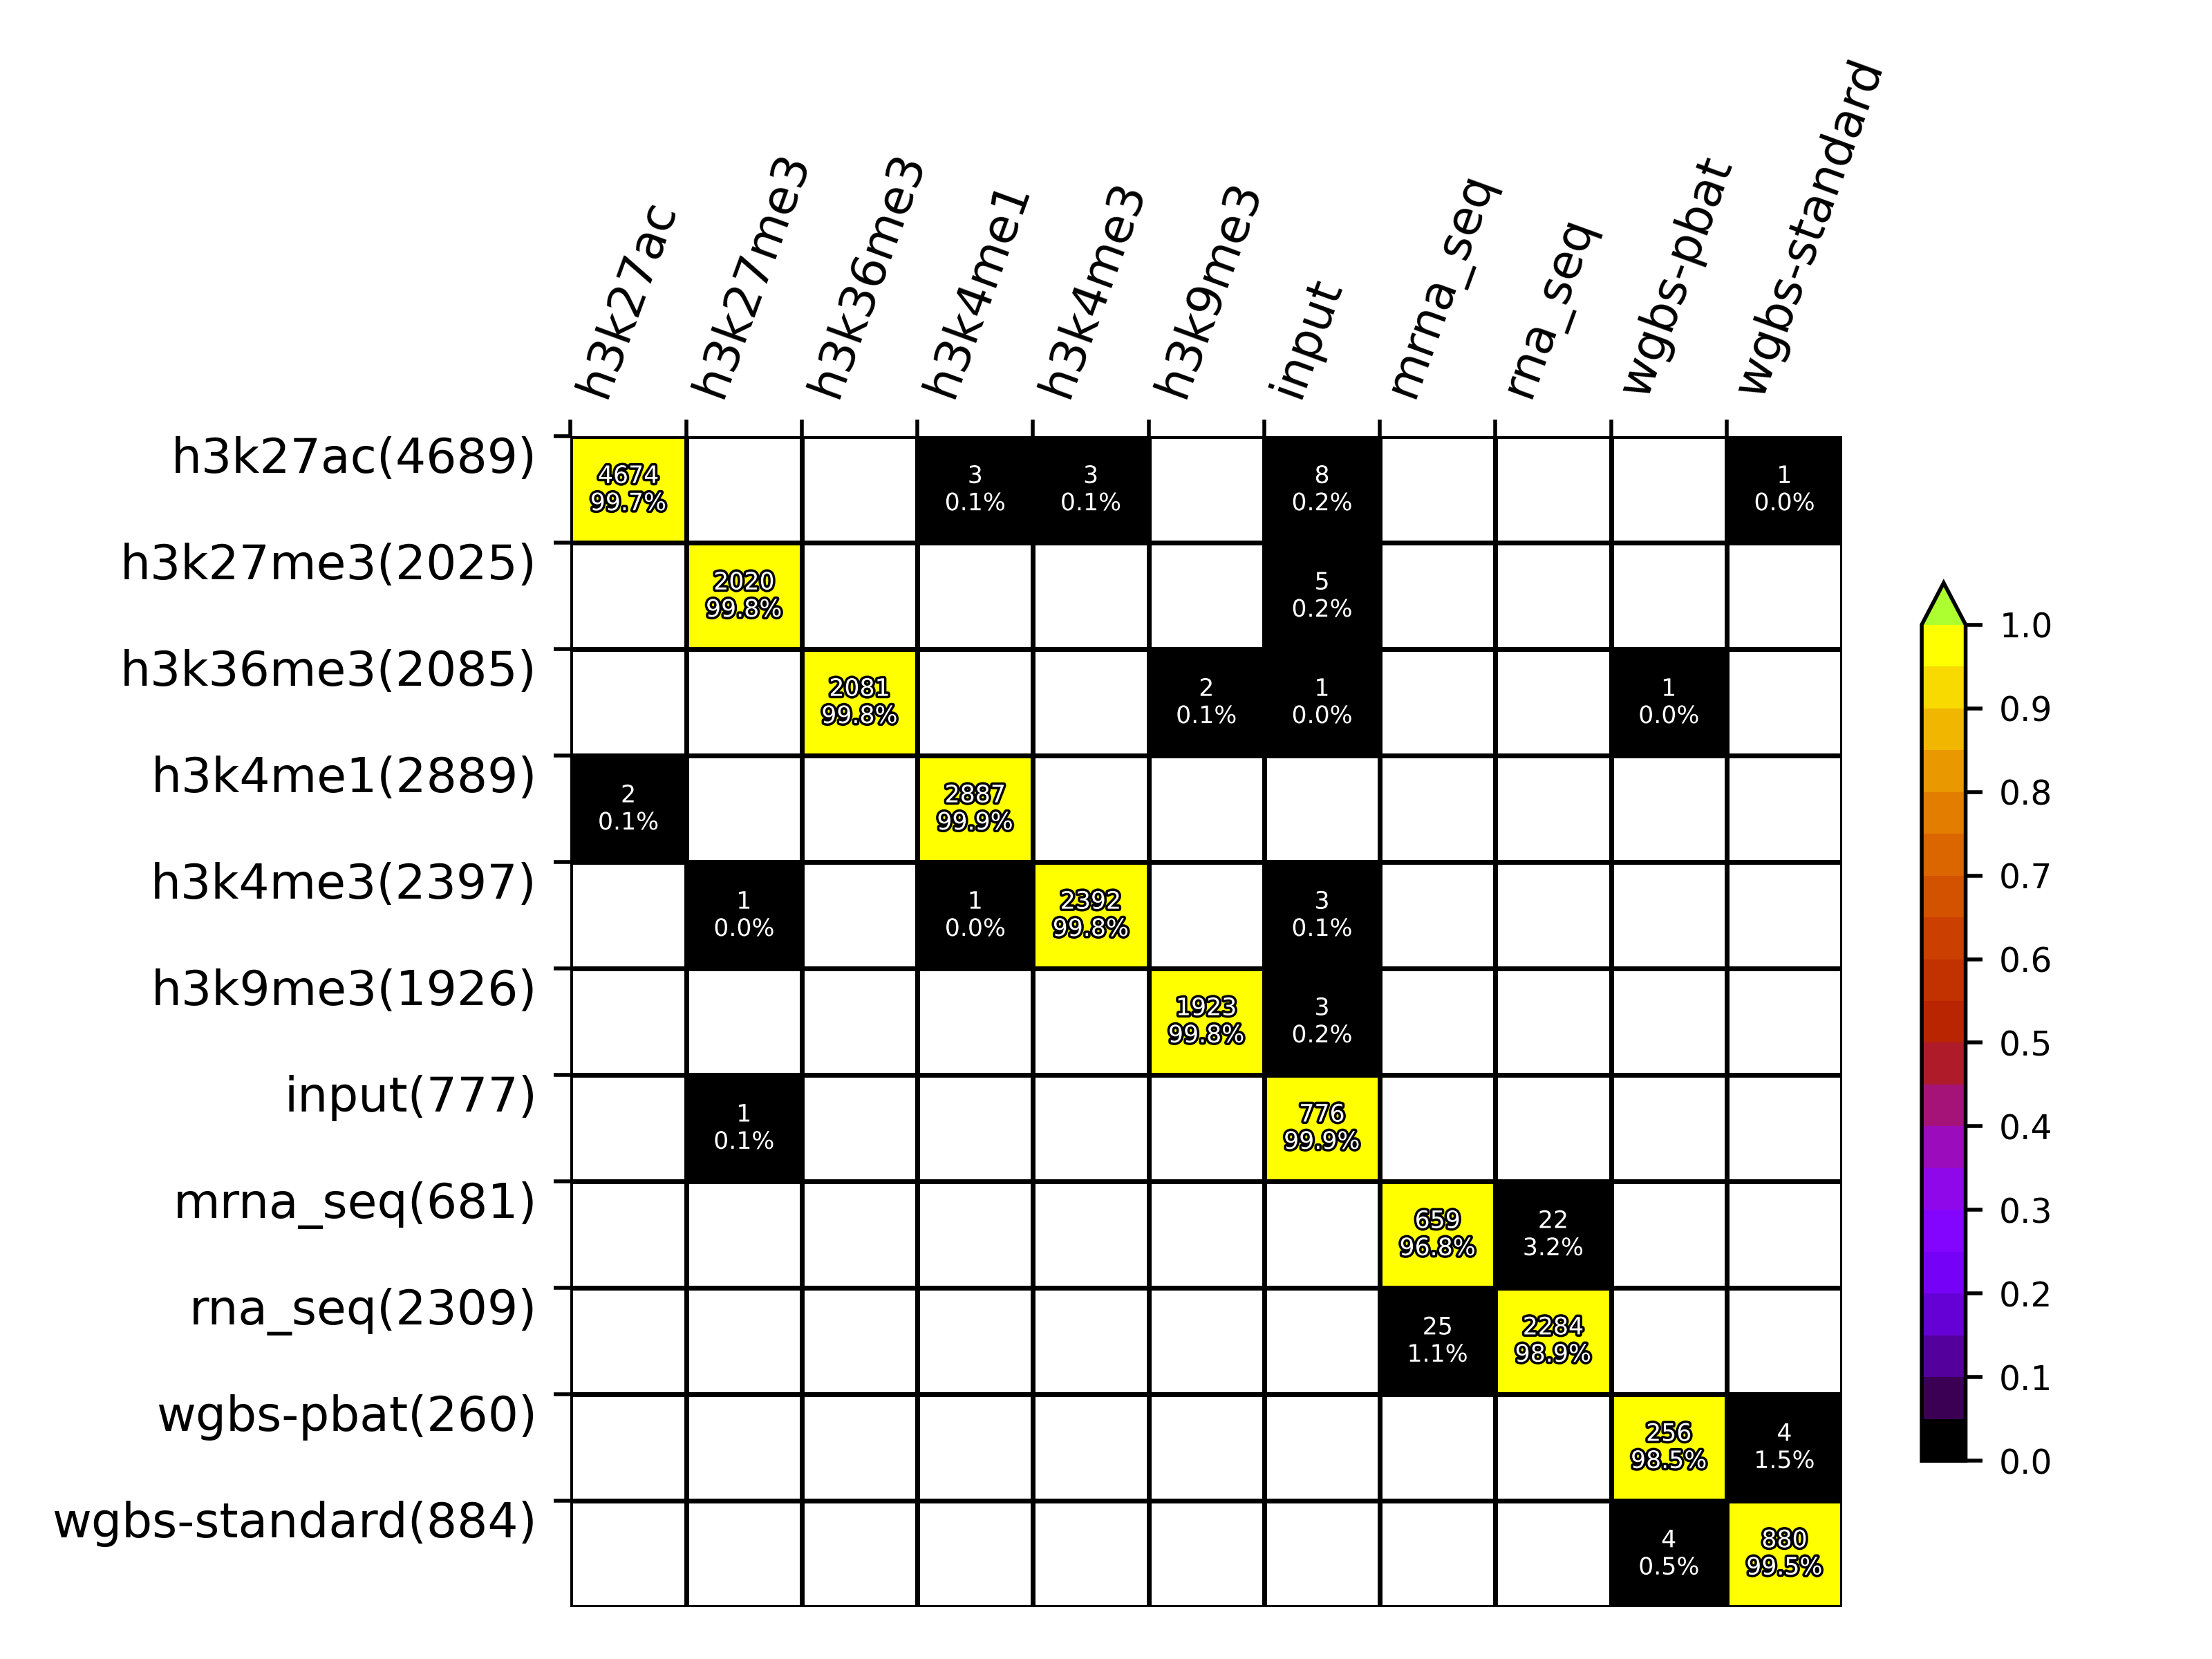

In [24]:
create_confusion_matrix(
    df=df_with_meta,
    min_pred_score=min_pred_score,
    # logdir=logdir,
    # name=name,
    majority=majority,
)

## Supp Fig 1

### Supp Fig 1A,1B - All classifiers metrics on EpiAtlas - Assay and Biospecimen - 100kb resolution

Fig 1A,1B: data points are included here.

In [25]:
def plot_multiple_models_split_metrics(
    split_metrics: Dict[str, Dict[str, Dict[str, float]]],
    label_category: str,
    logdir: Path | None = None,
    filename: str = "fig1_all_classifiers_metrics",
) -> None:
    """Render to box plots the metrics per classifier/models and split, each in its own subplot.

    Args:
        split_metrics: A dictionary containing metric scores for each classifier and split.
        label_category: The label category for the classification task.
        name: The name of the figure.
        logdir: The directory to save the figure to. If None, the figure is only displayed.

    Returns:
        None: Displays the figure and saves it to the logdir if provided.
    """
    metrics = ["Accuracy", "F1_macro", "AUC_micro", "AUC_macro"]
    classifier_names = list(next(iter(split_metrics.values())).keys())
    classifier_names = ["NN", "LR", "LGBM", "LinearSVC", "RF"]

    # Create subplots, one row for each metric
    fig = make_subplots(
        rows=1,
        cols=len(metrics),
        subplot_titles=metrics,
        horizontal_spacing=0.075,
    )

    for i, metric in enumerate(metrics):
        for classifier in classifier_names:
            values = [split_metrics[split][classifier][metric] for split in split_metrics]
            if classifier == "NN":
                classifier = "MLP"
            fig.add_trace(
                go.Box(
                    y=values,
                    name=classifier,
                    line=dict(color="black", width=1.5),
                    marker=dict(size=3, color="black"),
                    boxmean=True,
                    boxpoints="all",  # or "outliers" to show only outliers
                    pointpos=-1.4,
                    showlegend=False,
                    width=0.5,
                    hovertemplate="%{text}",
                    text=[
                        f"{split}: {value:.4f}"
                        for split, value in zip(split_metrics, values)
                    ],
                ),
                row=1,
                col=i + 1,
            )

    fig.update_layout(
        title_text=f"{label_category} classification - Metric distribution for 10fold cross-validation",
        yaxis_title="Value",
        boxmode="group",
    )

    # Adjust y-axis
    if label_category == ASSAY:
        range_acc = [0.95, 1.001]
        range_AUC = [0.992, 1.0001]
    elif label_category == CELL_TYPE:
        range_acc = [0.81, 1]
        range_AUC = [0.96, 1]
    else:
        range_acc = [0.6, 1.001]
        range_AUC = [0.9, 1.0001]

    fig.update_layout(yaxis=dict(range=range_acc))
    fig.update_layout(yaxis2=dict(range=range_acc))
    fig.update_layout(yaxis3=dict(range=range_AUC))
    fig.update_layout(yaxis4=dict(range=range_AUC))

    # Save figure
    if logdir:
        fig.write_image(logdir / f"{filename}.svg")
        fig.write_image(logdir / f"{filename}.png")
        fig.write_html(logdir / f"{filename}.html")

    fig.show()

In [26]:
merge_assays = True

for label_category in [ASSAY, CELL_TYPE]:
    all_split_dfs = split_results_handler.gather_split_results_across_methods(
        results_dir=data_dir_100kb,
        label_category=label_category,
        only_NN=False,
    )

    if merge_assays and label_category == ASSAY:
        for split_name, split_dfs in all_split_dfs.items():
            for classifier_type, df in split_dfs.items():
                split_dfs[classifier_type] = merge_similar_assays(df)

    split_metrics = split_results_handler.compute_split_metrics(all_split_dfs)

    plot_multiple_models_split_metrics(
        split_metrics,
        label_category=label_category,
    )

**Going forward, all results are for MLP classifiers.**

### Supp Fig 1C - ROC curves - Assay and Biospecimen

In [27]:
def plot_roc_curves(
    results_df: pd.DataFrame,
    label_category: str,
    logdir: Path | None = None,
    name: str = "roc_curve",
    title: str | None = None,
    colors_dict: Dict | None = None,  # Optional specific colors
) -> None:
    """
    Generates and plots ROC curves for multi-class classification results using Plotly.

    Calculates and plots individual class ROC curves, micro-average, and macro-average ROC curves.

    Args:
        results_df (pd.DataFrame): DataFrame with true labels and prediction probabilities for each class.
                                   Must contain the `label_category` column (e.g., 'True class')
                                   and probability columns named after each class.
        label_category (str): The column name containing the true labels (e.g., 'True class', ASSAY, CELL_TYPE).
        logdir (Path | None): Directory to save the figure. If None, only displays the figure.
        name (str): Base name for saved files (e.g., "supp_fig1e").
        title (str | None): Title suffix for the plot. If None, a default title based on label_category is used.
        colors_dict (Dict | None): Optional dictionary mapping class names to colors. If None or a class
                                   is missing, default Plotly colors are used.
    """
    df = results_df.copy()
    true_label_col = "True class"  # Assuming 'True class' holds the ground truth labels

    if true_label_col not in df.columns:
        raise ValueError(f"True label column '{true_label_col}' not found in DataFrame.")

    classes = sorted(df[true_label_col].unique())
    print(f"Using classes: {classes}")

    n_classes = len(classes)
    if n_classes < 2:
        print(
            f"Warning: Only {n_classes} class found after processing. Cannot generate ROC curve."
        )
        return

    # Check if probability columns exist for all determined classes
    missing_cols = [c for c in classes if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing probability columns for classes: {missing_cols}")

    # Binarize the true labels against the final set of classes
    try:
        y_true = label_binarize(df[true_label_col], classes=classes)
    except ValueError as e:
        raise ValueError(
            f"Error binarizing labels for classes {classes}. Check if all labels in '{true_label_col}' are included in 'classes'."
        ) from e

    if n_classes == 2 and y_true.shape[1] == 1:
        # Adjust for binary case where label_binarize might return one column
        y_true = np.hstack((1 - y_true, y_true))  # type: ignore
    elif y_true.shape[1] != n_classes:
        raise ValueError(
            f"Binarized labels shape {y_true.shape} does not match number of classes {n_classes}"
        )

    # Get the predicted probabilities for each class
    # Ensure columns are in the same order as 'classes'
    y_score = df[classes].values

    # --- Compute ROC curve and ROC area for each class ---
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, class_name in enumerate(classes):
        try:
            fpr[class_name], tpr[class_name], _ = roc_curve(
                y_true=y_true[:, i], y_score=y_score[:, i]  # type: ignore
            )
            roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
        except ValueError as e:
            raise ValueError("Could not compute ROC for class {class_name}.") from e

    # --- Compute micro-average ROC curve and ROC area ---
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())  # type: ignore
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    except ValueError as e:
        raise ValueError("Could not compute micro-average ROC.") from e

    # --- Compute macro-average ROC curve and ROC area ---
    try:
        # Aggregate all false positive rates
        all_fpr = np.unique(
            np.concatenate(
                [fpr[class_name] for class_name in classes if class_name in fpr]
            )
        )
        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        valid_classes_count = 0
        for class_name in classes:
            if class_name in fpr and class_name in tpr:
                mean_tpr += np.interp(all_fpr, fpr[class_name], tpr[class_name])
                valid_classes_count += 1

        # Average it and compute AUC
        if valid_classes_count > 0:
            mean_tpr /= valid_classes_count
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        else:
            raise ValueError("No valid classes found for macro averaging.")

    except ValueError as e:
        raise ValueError("Could not compute macro-average ROC.") from e

    # --- Plot all ROC curves ---
    fig = go.Figure()

    # Plot diagonal line for reference
    fig.add_shape(
        type="line", line=dict(dash="dash", color="grey", width=1), x0=0, x1=1, y0=0, y1=1
    )

    # Define colors for plotting
    color_cycle = px.colors.qualitative.Plotly  # Default cycle
    plot_colors = {}
    for i, cls_name in enumerate(classes):
        if colors_dict and cls_name in colors_dict:
            plot_colors[cls_name] = colors_dict[cls_name]
        else:
            plot_colors[cls_name] = color_cycle[i % len(color_cycle)]

    # Plot Micro-average ROC curve first (often plotted thicker/dashed)
    fig.add_trace(
        go.Scatter(
            x=fpr["micro"],
            y=tpr["micro"],
            mode="lines",
            name=f'Micro-average ROC (AUC = {roc_auc["micro"]:.5f})',
            line=dict(color="deeppink", width=3, dash="dash"),
            hoverinfo="skip",  # Less important for hover usually
        )
    )

    # Plot Macro-average ROC curve
    fig.add_trace(
        go.Scatter(
            x=fpr["macro"],
            y=tpr["macro"],
            mode="lines",
            name=f'Macro-average ROC (AUC = {roc_auc["macro"]:.5f})',
            line=dict(color="navy", width=3, dash="dash"),
            hoverinfo="skip",
        )
    )

    # Plot individual class ROC curves
    for class_name in classes:
        if class_name not in fpr or class_name not in tpr or class_name not in roc_auc:
            continue  # Skip if calculation failed
        fig.add_trace(
            go.Scatter(
                x=fpr[class_name],
                y=tpr[class_name],
                mode="lines",
                name=f"{class_name} (AUC = {roc_auc[class_name]:.5f})",
                line=dict(width=1.5, color=plot_colors.get(class_name)),
                hovertemplate=f"<b>{class_name}</b><br>FPR=%{{x:.5f}}<br>TPR=%{{y:.5f}}<extra></extra>",  # Show class name and values on hover
            )
        )

    # --- Update layout ---
    base_title = f"ROC Curves - {label_category}"
    plot_title = f"{base_title} - {title}" if title else base_title

    fig.update_layout(
        title=plot_title,
        xaxis_title="False Positive Rate (1 - Specificity)",
        yaxis_title="True Positive Rate (Sensitivity)",
        xaxis=dict(range=[0.0, 1.0], constrain="domain"),  # Ensure axes range 0-1
        yaxis=dict(
            range=[0.0, 1.05], scaleanchor="x", scaleratio=1, constrain="domain"
        ),  # Make it square-ish, slight top margin
        width=800,
        height=750,
        hovermode="closest",
        legend=dict(
            traceorder="reversed",  # Show averages first in legend
            title="Classes & Averages",
            font=dict(size=9),
            itemsizing="constant",
        ),
        margin=dict(l=60, r=30, t=80, b=60),
    )

    # --- Save figure if logdir is provided ---
    if logdir:
        logdir.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
        filename_base = f"{name}_{label_category}_roc"
        filepath_base = logdir / filename_base

        fig.write_html(f"{filepath_base}.html")
        fig.write_image(f"{filepath_base}.svg", width=800, height=750)
        fig.write_image(f"{filepath_base}.png", width=800, height=750, scale=2)

        print(f"Saved ROC curve plots for {label_category} to {logdir}")
        print(f" -> {filename_base}.html / .svg / .png")

    fig.show()

In [28]:
data_dir = (
    mixed_data_dir
    / "hg38_100kb_all_none"
    / f"{ASSAY}_1l_3000n"
    / "11c"
    / "10fold-oversampling"
)
if not data_dir.exists():
    raise FileNotFoundError(f"Directory {data_dir} does not exist.")

dfs = split_results_handler.read_split_results(data_dir)
concat_df: pd.DataFrame = split_results_handler.concatenate_split_results(dfs, depth=1)  # type: ignore
concat_df = split_results_handler.add_max_pred(concat_df)
concat_df_w_meta = metadata_handler.join_metadata(concat_df, metadata_v2)

df = merge_similar_assays(concat_df_w_meta.copy())
N_error = (df["True class"] != df["Predicted class"]).sum()
print(f"Only {N_error}/{len(df)} errors. ({N_error/len(df):.3%} error rate)")

Only 35/20922 errors. (0.167% error rate)


In [29]:
logdir = base_fig_dir / "fig2_EpiAtlas_other" / "ROC_curves"
plot_roc_curves(
    results_df=df.copy(),
    label_category=ASSAY,
    # logdir=logdir,
    # name="aggregate", # File name prefix
    title="Aggregated 10fold",  # Title suffix
    colors_dict=assay_colors,
)

Using classes: ['h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k4me1', 'h3k4me3', 'h3k9me3', 'input', 'rna_seq', 'wgbs']


In [30]:
data_dir = (
    mixed_data_dir
    / "hg38_100kb_all_none"
    / f"{CELL_TYPE}_1l_3000n"
    / "10fold-oversampling"
)
if not data_dir.exists():
    raise FileNotFoundError(f"Directory {data_dir} does not exist.")

dfs = split_results_handler.read_split_results(data_dir)
concat_df: pd.DataFrame = split_results_handler.concatenate_split_results(dfs, depth=1)  # type: ignore
concat_df = split_results_handler.add_max_pred(concat_df)
concat_df_w_meta = metadata_handler.join_metadata(concat_df, metadata_v2)

In [31]:
plot_roc_curves(
    results_df=concat_df_w_meta,
    label_category=CELL_TYPE,
    # logdir=logdir,
    # name="aggregate", # File name prefix
    title="Aggregated 10fold",  # Title suffix
    colors_dict=cell_type_colors,
)

Using classes: ['T cell', 'brain', 'colon', 'connective tissue cell', 'endoderm-derived structure', 'extraembryonic cell', 'hepatocyte', 'lymphocyte of B lineage', 'macrophage', 'mammary gland epithelial cell', 'mesoderm-derived structure', 'monocyte', 'muscle organ', 'myeloid cell', 'neutrophil', 'venous blood']


### Supp Fig 1D - Metrics for zeroed blacklist values and winsorized files - 100kb resolution

In [32]:
def create_blklst_graphs(
    feature_set_metrics_dict: Dict[str, Dict[str, Dict[str, Dict[str, float]]]],
    logdir: Path | None = None,
) -> None:
    """Create boxplots for blacklisted related feature sets.

    Args:
        feature_set_metrics_dict (Dict[str, Dict[str, Dict[str, Dict[str, float]]]]): The dictionary containing all metrics for all blklst related feature sets.
            format: {feature_set: {task_name: {split_name: metric_dict}}}
        logdir (Path, Optional): The directory to save the figure to. If None, the figure is only displayed.
    """
    # Assume names exist in all feature sets
    task_names = list(feature_set_metrics_dict.values())[0].keys()

    traces_names_dict = {
        "hg38_100kb_all_none": "observed",
        "hg38_100kb_all_none_0blklst": "0blklst",
        "hg38_100kb_all_none_0blklst_winsorized": "0blklst_winsorized",
    }

    for task_name in task_names:
        category_fig = make_subplots(
            rows=1,
            cols=2,
            shared_yaxes=False,
            subplot_titles=["Accuracy", "F1-score (macro)"],
            x_title="Feature set",
            y_title="Metric value",
            horizontal_spacing=0.1,
        )
        for feature_set_name, tasks_dicts in feature_set_metrics_dict.items():
            task_dict = tasks_dicts[task_name]
            trace_name = traces_names_dict[feature_set_name]

            # Accuracy
            metric = "Accuracy"
            y_vals = [task_dict[split][metric] for split in task_dict]  # type: ignore
            hovertext = [
                f"{split}: {metrics_dict[metric]:.4f}"  # type: ignore
                for split, metrics_dict in task_dict.items()
            ]

            category_fig.add_trace(
                go.Box(
                    y=y_vals,
                    name=trace_name,
                    boxmean=True,
                    boxpoints="all",
                    showlegend=False,
                    marker=dict(size=3, color="black"),
                    line=dict(width=1, color="black"),
                    hovertemplate="%{text}",
                    text=hovertext,
                ),
                row=1,
                col=1,
            )

            metric = "F1_macro"
            y_vals = [task_dict[split][metric] for split in task_dict]  # type: ignore
            hovertext = [
                f"{split}: {metrics_dict[metric]:.4f}"  # type: ignore
                for split, metrics_dict in task_dict.items()
            ]
            category_fig.add_trace(
                go.Box(
                    y=y_vals,
                    name=trace_name,
                    boxmean=True,
                    boxpoints="all",
                    showlegend=False,
                    marker=dict(size=3, color="black"),
                    line=dict(width=1, color="black"),
                    hovertemplate="%{text}",
                    text=hovertext,
                ),
                row=1,
                col=2,
            )

        category_fig.update_xaxes(
            categoryorder="array",
            categoryarray=list(traces_names_dict.values()),
        )
        category_fig.update_yaxes(range=[0.85, 1.001])

        task_name = task_name.replace("_1l_3000n-10fold", "")
        category_fig.update_layout(
            title=f"MLP performance<br>{task_name}",
        )

        width = 500
        height = width * 1.5
        category_fig.update_layout(
            autosize=False,
            width=width,
            height=height,
        )
        # Save figure
        if logdir:
            base_name = f"metrics_{task_name}"
            category_fig.write_html(logdir / f"{base_name}.html")
            category_fig.write_image(logdir / f"{base_name}.svg")
            category_fig.write_image(logdir / f"{base_name}.png")

        category_fig.show()

In [33]:
include_sets = [
    "hg38_100kb_all_none",
    "hg38_100kb_all_none_0blklst",
    "hg38_100kb_all_none_0blklst_winsorized",
]

results_folder_blklst = base_data_dir / "training_results" / "2023-01-epiatlas-freeze"
if not results_folder_blklst.exists():
    raise FileNotFoundError(f"Folder '{results_folder_blklst}' not found")

In [34]:
# Select 10-fold oversampling runs
# expected result shape: {feature_set: {task_name: {split_name: metrics_dict}}}
all_metrics_blklst: Dict[
    str, Dict[str, Dict[str, Dict[str, float]]]
] = split_results_handler.obtain_all_feature_set_data(
    return_type="metrics",
    parent_folder=results_folder_blklst,
    merge_assays=True,
    include_categories=[ASSAY, CELL_TYPE],
    include_sets=include_sets,
    oversampled_only=False,
    verbose=False,
)  # type: ignore

In [35]:
logdir = base_fig_dir / "fig2_EpiAtlas_other/fig2--blklst_and_winsorized"
create_blklst_graphs(all_metrics_blklst, logdir=logdir)

### Supp Fig 1E,1F,1G - Distribution of average prediction scores per assay

- E: Assay training 10-fold validation
- F: Assay complete training, predictions on imputed data
- G: Biospecimen 10-fold validation

In [36]:
def plot_prediction_scores_distribution(
    results_df: pd.DataFrame,
    merge_assay_pairs: bool = True,
    logdir: Path | None = None,
    name: str = "prediction_score_distribution",
    group_by_column: str = "True class",
    min_y: float = 0.7,
    use_aggregate_vote: bool = True,
    title: str | None = None,
) -> None:
    """
    Creates a Plotly figure with violin plots and associated scatter plots for each group.
    Supports both aggregated and non-aggregated data visualization with enhanced styling.

    Args:
        results_df (pd.DataFrame): DataFrame containing prediction results and metadata
        merge_assay_pairs (bool): Whether to merge similar assays (mrna/rna, wgbs-pbat/wgbs-standard)
        logdir (Path | None): Directory to save figures. If None, only displays the figure
        name (str): Base name for saved files
        group_by_column (str): Column name to use for grouping traces
        merge_similar_assays (bool): Whether to merge similar assays (mrna/rna, wgbs-pbat/wgbs-standard)
        min_y (float): Minimum y-axis value
        use_aggregate_vote (bool): If True, aggregate by EpiRR. If False, use individual predictions
        title (str | None): Additional title text to append
    """
    fig = go.Figure()

    if merge_assay_pairs:
        try:
            results_df = merge_similar_assays(results_df)
        except ValueError as e:
            print(f"Skipping assay merging: {e}")

    # Group ordering
    if group_by_column == ASSAY and merge_assay_pairs:
        group_labels = ASSAY_ORDER
    else:
        group_labels = sorted(set(results_df[group_by_column].unique()))
    group_index = {label: i for i, label in enumerate(group_labels)}

    # Colors for each group
    if group_by_column == ASSAY:
        colors = assay_colors
    else:
        grey = "rgba(237, 231, 225, 1)"
        colors = {label: grey for label in group_labels}

    for label in group_labels:
        sub_df = results_df[results_df[group_by_column] == label]

        if use_aggregate_vote:
            # Aggregate by EpiRR with majority voting
            groupby = sub_df.groupby(["EpiRR", "Predicted class", "True class"])[
                "Max pred"
            ].aggregate(["size", "mean"])
            groupby = groupby.reset_index().sort_values(
                ["EpiRR", "size"], ascending=[True, False]
            )
            groupby = groupby.drop_duplicates(subset="EpiRR", keep="first")
            assert groupby["EpiRR"].is_unique
            mean_pred = groupby["mean"]

        else:
            # Use individual predictions
            mean_pred = sub_df["Max pred"]

        # Add violin plot
        fig.add_trace(
            go.Violin(
                x=[group_index[label]] * len(mean_pred),
                y=mean_pred,
                name=label,
                spanmode="hard",
                box_visible=True,
                meanline_visible=True,
                points="all",
                marker=dict(size=1, color="black"),
                fillcolor=colors[label],
                line=dict(width=0.5, color="white"),
                showlegend=False,
            )
        )

    # Update layout
    title_text = "Prediction Score Distribution"
    if use_aggregate_vote:
        title_text += " (EpiRR majority vote)"
    if title:
        title_text += f" - {title}"

    fig.update_layout(
        title_text=title_text,
        yaxis_title=(
            "Prediction Score"
            if not use_aggregate_vote
            else "Avg. Prediction Score (majority class)"
        ),
        xaxis_title=group_by_column,
        yaxis_range=[min_y, 1.001],
        xaxis=dict(
            tickvals=list(group_index.values()),
            ticktext=list(group_index.keys()),
        ),
        legend=dict(
            title_text="Legend",
            itemsizing="constant",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
        ),
    )

    # Save figure if logdir is provided
    if logdir:
        filename = f"{name}_epirr" if use_aggregate_vote else name
        fig.write_html(logdir / f"{filename}.html")
        fig.write_image(logdir / f"{filename}.svg")
        fig.write_image(logdir / f"{filename}.png")

    fig.show()

#### Supp Fig 1E: ASSAY - Prediction scores for 10-fold cross-validation

In [37]:
data_dir = (
    mixed_data_dir
    / "hg38_100kb_all_none"
    / f"{ASSAY}_1l_3000n"
    / "11c"
    / "10fold-oversampling"
)
if not data_dir.exists():
    raise FileNotFoundError(f"Directory {data_dir} does not exist.")

dfs = split_results_handler.read_split_results(data_dir)
concat_df: pd.DataFrame = split_results_handler.concatenate_split_results(dfs, depth=1)  # type: ignore
concat_df = split_results_handler.add_max_pred(concat_df)
concat_df_w_meta = metadata_handler.join_metadata(concat_df, metadata_v2)

In [38]:
plot_prediction_scores_distribution(
    results_df=concat_df_w_meta,
    group_by_column=ASSAY,
    merge_assay_pairs=True,
    min_y=0.7,
    title="11 classes assay training - Prediction scores for 10-fold cross-validation",
)

#### Supp Fig 1F: Biospecimen - Prediction scores for 10-fold cross-validation

In [39]:
data_dir = data_dir_100kb / f"{CELL_TYPE}_1l_3000n" / "10fold-oversampling"
if not data_dir.exists():
    raise FileNotFoundError(f"Directory {data_dir} does not exist.")

dfs = split_results_handler.read_split_results(data_dir)
concat_df: pd.DataFrame = split_results_handler.concatenate_split_results(dfs, depth=1)  # type: ignore
concat_df = split_results_handler.add_max_pred(concat_df)
concat_df_w_meta = metadata_handler.join_metadata(concat_df, metadata_v2)
concat_df_w_meta.replace({ASSAY: ASSAY_MERGE_DICT}, inplace=True)

In [40]:
plot_prediction_scores_distribution(
    results_df=concat_df_w_meta,
    group_by_column=ASSAY,
    min_y=0,
    title="Biospecimen training - Prediction scores for 10-fold cross-validation",
)

Skipping assay merging: Wrong results dataframe, rna or wgbs columns missing.


#### Supp Fig 1G: ASSAY - Classifier trained on full EpiATLAS data. Inference on imputed data (all pval)

In [41]:
metadata_path = (
    paper_dir
    / "data"
    / "metadata"
    / "epiatlas"
    / "imputed"
    / "hg38_epiatlas_imputed_pval_chip_2024-02.json"
)
metadata_imputed: pd.DataFrame = metadata_handler.load_any_metadata(metadata_path, as_dataframe=True)  # type: ignore

In [42]:
data_dir = (
    gen_data_dir
    / "hg38_100kb_all_none"
    / f"{ASSAY}_1l_3000n"
    / "11c"
    / "complete_no_valid_oversample"
    / "predictions"
    / "epiatlas_imputed"
    / "ChIP"
)
if not data_dir.exists():
    raise FileNotFoundError(f"Directory {data_dir} does not exist.")

df_pred = pd.read_csv(
    data_dir / "complete_no_valid_oversample_prediction.csv",
    index_col=0,
)
print(df_pred.shape)

(9570, 13)


In [43]:
assay_classes = list(metadata_v2_df[ASSAY].unique())
df_pred = split_results_handler.add_max_pred(df_pred, expected_classes=assay_classes)
print(df_pred.shape)

(9570, 14)


In [44]:
augmented_df = pd.merge(df_pred, metadata_imputed, left_index=True, right_on="md5sum")
augmented_df["True class"] = augmented_df[ASSAY]
augmented_df["True class"].value_counts(dropna=False)

h3k36me3    1703
h3k27me3    1703
h3k9me3     1700
h3k4me1     1688
h3k4me3     1688
h3k27ac     1088
Name: True class, dtype: int64

In [45]:
this_logdir = base_fig_dir / "fig1_EpiAtlas_assay" / "pred_score_imputed"
plot_prediction_scores_distribution(
    results_df=augmented_df,
    group_by_column=ASSAY,
    merge_assay_pairs=True,
    min_y=0.79,
    use_aggregate_vote=False,
    title="Complete 11c assay classifier, inference on imputed data",
    # logdir=this_logdir,
)

### Supp Fig 1H,I

See `src/python/epi_ml/utils/notebooks/paper/confidence_threshold.ipynb`.

## Supp Fig 2 - Various feature sets performance per assay - Biospecimen

### Supp Fig 2A-B

In [46]:
metrics_supp2 = {name: all_metrics[name] for name in feature_sets_14}

graph_feature_set_metrics(
    all_metrics=metrics_supp2,  # type: ignore
    input_sizes=input_sizes,
    boxpoints="all",
)

### Supp Fig 2-rest

In [47]:
def prepare_metric_sets_per_assay(
    all_results: Dict[str, Dict[str, Dict[str, pd.DataFrame]]], verbose: bool = False
) -> Dict[str, Dict[str, Dict[str, Dict[str, Dict[str, float]]]]]:
    """Prepare metric sets per assay.

    Args:
        all_results (Dict[str, Dict[str, Dict[str, pd.DataFrame]]]): A dictionary containing all results for all feature sets.

    Returns:
        Dict[str, Dict[str, Dict[str, Dict[str, float]]]]: A dictionary containing all metrics per assay for all feature sets.
            Format: {assay: {feature_set: {task_name: {split_name: metric_dict}}}}
    """
    if verbose:
        print("Loading metadata.")
    metadata = metadata_handler.load_metadata("v2")
    metadata.convert_classes(ASSAY, ASSAY_MERGE_DICT)
    md5_per_assay = metadata.md5_per_class(ASSAY)
    md5_per_assay = {k: set(v) for k, v in md5_per_assay.items()}

    if verbose:
        print("Getting results per assay.")
    results_per_assay = {}
    for assay_label in ASSAY_ORDER:
        if verbose:
            print(assay_label)
        results_per_assay[assay_label] = {}
        for feature_set, task_dict in all_results.items():
            if verbose:
                print(feature_set)
            results_per_assay[assay_label][feature_set] = {}
            for task_name, split_dict in task_dict.items():
                if verbose:
                    print(task_name)
                results_per_assay[assay_label][feature_set][task_name] = {}

                # Only keep the relevant assay
                for split_name, split_df in split_dict.items():
                    if verbose:
                        print(split_name)
                    assay_df = split_df[split_df.index.isin(md5_per_assay[assay_label])]
                    results_per_assay[assay_label][feature_set][task_name][
                        split_name
                    ] = assay_df

    if verbose:
        print("Finished getting results per assay. Now computing metrics.")
    metrics_per_assay = {}
    for assay_label in ASSAY_ORDER:
        if verbose:
            print(assay_label)
        metrics_per_assay[assay_label] = {}
        for feature_set, task_dict in results_per_assay[assay_label].items():
            if verbose:
                print(feature_set)
            assay_metrics = split_results_handler.compute_split_metrics(
                task_dict, concat_first_level=True
            )
            inverted_dict = split_results_handler.invert_metrics_dict(assay_metrics)
            metrics_per_assay[assay_label][feature_set] = inverted_dict

    return metrics_per_assay

In [48]:
def graph_feature_set_metrics_per_assay(
    all_metrics_per_assay: Dict[str, Dict[str, Dict[str, Dict[str, Dict[str, float]]]]],
    input_sizes: Dict[str, int],
    logdir: Path | None = None,
    sort_by_input_size: bool = False,
    name: str | None = None,
    y_range: Tuple[float, float] | None = None,
    boxpoints: str = "outliers",
) -> None:
    """Graph the metrics for all feature sets, per assay, with separate plots for accuracy and F1-score.

    Args:
        all_metrics_per_assay (Dict[str, Dict[str, Dict[str, Dict[str, Dict[str, float]]]]]): A dictionary containing all metrics per assay for all feature sets.
            Format: {assay: {feature_set: {task_name: {split_name: metric_dict}}}}
        input_sizes (Dict[str, int]): A dictionary containing the input sizes for all feature sets.
        logdir (Path): The directory where the figures will be saved. If None, the figures will only be displayed.
        sort_by_input_size (bool): Whether to sort the feature sets by input size.
        name (str|None): The name of the figure.
        y_range (Tuple[float, float]|None): The y-axis range for the plots.
        boxpoints (str): The type of points to display in the box plots. Defaults to "outliers".
    """
    valid_boxpoints = ["all", "outliers"]
    if boxpoints not in valid_boxpoints:
        raise ValueError(f"Invalid boxpoints value. Choose from {valid_boxpoints}.")

    fig_assay_order = [
        "rna_seq",
        "h3k27ac",
        "h3k4me1",
        "h3k4me3",
        "h3k36me3",
        "h3k27me3",
        "h3k9me3",
        "input",
        "wgbs",
    ]

    reference_assay = next(iter(all_metrics_per_assay))
    reference_feature_set = next(iter(all_metrics_per_assay[reference_assay]))
    metadata_categories = list(
        all_metrics_per_assay[reference_assay][reference_feature_set].keys()
    )

    for _, category in enumerate(metadata_categories):
        for metric, metric_name in [
            ("Accuracy", "Accuracy"),
            ("F1_macro", "F1-score (macro)"),
        ]:
            fig = go.Figure()

            feature_sets = list(all_metrics_per_assay[reference_assay].keys())
            unique_feature_sets = set(feature_sets)
            for assay in fig_assay_order:
                if set(all_metrics_per_assay[assay].keys()) != unique_feature_sets:
                    raise ValueError("Different feature sets through assays.")

            feature_set_order = feature_sets
            if sort_by_input_size:
                feature_set_order = sorted(
                    feature_set_order, key=lambda x: input_sizes[x]
                )

            # Adjust spacing so each assay group has dedicated space based on the number of feature sets
            spacing_multiplier = (
                1.1  # Increase this multiplier if needed to add more spacing
            )
            x_positions = {
                assay: i * len(feature_set_order) * spacing_multiplier
                for i, assay in enumerate(fig_assay_order)
            }

            for i, feature_set_name in enumerate(feature_set_order):
                resolution = (
                    feature_set_name.replace("_none", "")
                    .replace("hg38_", "")
                    .split("_")[0]
                )
                color = resolution_colors[resolution]
                display_name = feature_set_name.replace("_none", "").replace("hg38_", "")

                for assay in fig_assay_order:
                    if feature_set_name not in all_metrics_per_assay[assay]:
                        continue

                    tasks_dicts = all_metrics_per_assay[assay][feature_set_name]

                    if feature_set_name not in input_sizes:
                        print(f"Skipping {feature_set_name}, no input size found.")
                        continue

                    task_name = category
                    if "split" in task_name:
                        raise ValueError("Split in task name. Wrong metrics dict.")

                    try:
                        task_dict = tasks_dicts[task_name]
                    except KeyError:
                        print(
                            f"Skipping {feature_set_name}, {task_name} for assay {assay}"
                        )
                        continue

                    y_vals = [task_dict[split][metric] for split in task_dict]
                    hovertext = [
                        f"{assay} - {display_name} - {split}: {metrics_dict[metric]:.4f}"
                        for split, metrics_dict in task_dict.items()
                    ]

                    x_position = x_positions[assay] + i
                    fig.add_trace(
                        go.Box(
                            x=[x_position] * len(y_vals),
                            y=y_vals,
                            name=f"{assay}|{display_name}",
                            boxmean=True,
                            boxpoints=boxpoints,
                            marker=dict(size=3, color="black"),
                            line=dict(width=1, color="black"),
                            fillcolor=color,
                            hovertemplate="%{text}",
                            text=hovertext,
                            showlegend=False,
                            legendgroup=display_name,
                        )
                    )

                    # separate box groups
                    fig.add_vline(
                        x=x_positions[assay] - 1, line_width=1, line_color="black"
                    )

            # Add dummy traces for the legend
            for feature_set_name in feature_set_order:
                resolution = (
                    feature_set_name.replace("_none", "")
                    .replace("hg38_", "")
                    .split("_")[0]
                )
                color = resolution_colors[resolution]
                display_name = feature_set_name.replace("_none", "").replace("hg38_", "")

                fig.add_trace(
                    go.Scatter(
                        name=display_name,
                        x=[None],
                        y=[None],
                        mode="markers",
                        marker=dict(size=10, color=color),
                        showlegend=True,
                        legendgroup=display_name,
                    )
                )

            title = f"Neural network performance - {category} - {metric_name} (per assay)"
            if name is not None:
                title += f" - {name}"
            fig.update_layout(
                width=1500,
                height=1000,
                title=title,
                xaxis_title="Assay",
                yaxis_title=metric_name,
            )

            # Create x-axis labels
            fig.update_xaxes(
                tickmode="array",
                tickvals=[
                    x_positions[assay] + len(feature_set_order) / 2
                    for assay in fig_assay_order
                ],
                ticktext=list(x_positions.keys()),
                title="Assay",
            )

            fig.update_layout(
                legend=dict(
                    title="Feature Sets", itemsizing="constant", traceorder="normal"
                )
            )
            if y_range:
                fig.update_yaxes(range=y_range)

            if logdir:
                base_name = f"feature_set_metrics_{category}_{metric}_per_assay"
                if name is not None:
                    base_name = base_name + f"_{name}"
                fig.write_html(logdir / f"{base_name}.html")
                fig.write_image(logdir / f"{base_name}.svg")
                fig.write_image(logdir / f"{base_name}.png")

            fig.show()

In [49]:
set_selection_name = "feature_sets_14"
all_results = split_results_handler.obtain_all_feature_set_data(
    parent_folder=mixed_data_dir,
    merge_assays=True,
    return_type="split_results",
    include_categories=[CELL_TYPE],
    include_sets=metric_orders_map[set_selection_name],
    exclude_names=["16ct", "27ct", "7c", "chip-seq-only"],
)

In [50]:
root_logger = logging.getLogger()
root_logger.setLevel(logging.ERROR)
metrics_per_assay = prepare_metric_sets_per_assay(all_results)  # type: ignore
root_logger.setLevel(logging.WARNING)

In [51]:
# Reorder feature sets
feature_set_order = metric_orders_map[set_selection_name]
for assay, feature_sets in list(metrics_per_assay.items()):
    metrics_per_assay[assay] = {
        feature_set_name: metrics_per_assay[assay][feature_set_name]
        for feature_set_name in feature_set_order
    }

In [52]:
graph_feature_set_metrics_per_assay(
    all_metrics_per_assay=metrics_per_assay,  # type: ignore
    input_sizes=input_sizes,
    boxpoints="all",
    sort_by_input_size=False,
)

### Table creation - Metrics per assay, various feature sets

In [53]:
all_results = split_results_handler.obtain_all_feature_set_data(
    parent_folder=mixed_data_dir,
    merge_assays=True,
    return_type="split_results",
    include_categories=[ASSAY, CELL_TYPE],
    include_sets=None,
    exclude_names=["16ct", "27ct", "7c", "chip-seq-only"],
)

In [55]:
# Prepare all results for MetricsPerAssay, which only deals with one DF at a time
# That class was built for dealing with merged dfs of all different classification tasks predictions, not for this
all_results_concat = {}
for set_name, split_results in all_results.items():
    concat_results = split_results_handler.concatenate_split_results(
        split_results, concat_first_level=True  # type: ignore
    )
    new_concat_results = {}
    for task_name, task_df in list(concat_results.items()):
        if task_name == "assay_epiclass_11c":
            new_task_name = ASSAY
        else:
            new_task_name = task_name
        assert isinstance(task_df, pd.DataFrame)
        new_concat_df = split_results_handler.add_max_pred(task_df)
        new_concat_df = pd.merge(
            new_concat_df,
            metadata_v2_df[[ASSAY, CELL_TYPE]],
            left_index=True,
            right_index=True,
            how="inner",
            suffixes=("", "_DROP"),
        )
        new_concat_df = new_concat_df.drop(
            columns=[col for col in new_concat_df.columns if col.endswith("_DROP")]
        )
        new_concat_results[new_task_name] = new_concat_df
    all_results_concat[set_name] = new_concat_results

In [56]:
metrics_per_assay = defaultdict(dict)
for set_name, all_tasks in all_results_concat.items():
    for task_name, task_df in all_tasks.items():
        metrics_per_assay[set_name][task_name] = MetricsPerAssay().compute_all_chunked_acc_per_assay(  # type: ignore
            all_preds=task_df,
            categories=[task_name],
            no_epiatlas=False,
            merge_assays=True,
            column_templates={
                "True": "True class",
                "Predicted": "Predicted class",
                "Max pred": "Max pred",
            },
            verbose=False,
        )

In [57]:
metrics_dfs = []
for set_name, task_dict in metrics_per_assay.items():
    concat_results = []
    for task_name, task_metrics in task_dict.items():
        metrics_df = MetricsPerAssay().create_metrics_dataframe(
            input_metrics=task_metrics,
            chunked=True,
        )
        concat_results.append(metrics_df)
    new_df = pd.concat(concat_results, axis=0)
    new_df.insert(loc=0, column="feature_set", value=set_name)
    metrics_dfs.append(new_df)

full_metrics_df = pd.concat(metrics_dfs, axis=0)

In [58]:
output_dir = paper_dir / "tables" / "dfreeze_v2"
full_metrics_df.to_csv(
    output_dir / "all_EpiATLAS_metrics_per_assay_various_feature_sets.csv",
    index=False,
    na_rep="NA",
)